# Experiment 01: Hyperparameter study prompt-to-prompt editing


Research by Linn Bieske, forked code based Copyright 2022 Google LLC, Licensed under the Apache License, Version 2.0

The goal of this research is to further advance prompt-based editing techniques that rely on text prompts only. For example changing the haircolor while maintaining facial features.

## Notebook setup

### Installations

In [2]:
!pip install diffusers==0.3.0
!pip install transformers
!pip install ftfy
!pip install opencv-python
!pip install ipywidgets
!pip install diffusers
!pip install transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.9/153.9 kB 11.0 MB/s eta 0:00:00
  Attempting uninstall: diffusers
    Found existing installation: diffusers 0.30.3
    Uninstalling diffusers-0.30.3:
      Successfully uninstalled diffusers-0.30.3
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 62.6 MB/s eta 0:00:00


In [3]:
!pip uninstall -y tensorflow && pip install tensorflow-cpu

Found existing installation: tensorflow 2.17.0
Uninstalling tensorflow-2.17.0:
  Successfully uninstalled tensorflow-2.17.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.0/230.0 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 62.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 114.7 MB/s eta 0:00:00
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.17.0
    Uninstalling tensorboard-2.17.0:
      Successfully uninstalled tensorboard-2.17.0
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1


### Imports & drive mounting

In [3]:
# set colab path
from google.colab import drive
import os
import sys

drive.mount('/content/drive')
os.chdir('/content')  # This changes the current working directory to /content

Mounted at /content/drive


In [4]:
path = '/content/drive/My Drive/prompt-to-prompt'
sys.path.append(path)

In [5]:
from typing import Union, Tuple, List, Callable, Dict, Optional
import torch
import torch.nn.functional as nnf
from diffusers import DiffusionPipeline
import numpy as np
from IPython.display import display, Image
from PIL import Image
import abc
import json
import imageio
import os
from typing import List
import matplotlib.pyplot as plt

sys.path.append(os.path.abspath(path + '/utils'))
from utils import ptp_utils
from utils import seq_aligner
from utils import attention
from configs.config import config

### Load configuration

In [7]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
model_id = config['model_id']
NUM_DIFFUSION_STEPS = config['num_diffusion_steps']
GUIDANCE_SCALE = config['guidance_scale']
MAX_NUM_WORDS = config['max_num_words']
path_model = path + 'model/ldm_model.pt'
path_exp_01 = path + '/results/experiment_01_hyperparameters/'
save_model = False
load_from_disk = False

### Functions

#### Calling stable diffusion pipeline

In [8]:
def run_and_display(
    ldm,
    prompts,
    controller,
    show_images = True,
    latent=None,
    run_baseline=True,
    callback: Optional[Callable[[np.ndarray], np.ndarray]] = None,
    generator=None
):
    """
    Generates and displays images based on prompts using a specified controller.

    Args:
        prompts (list of str): Text prompts for image generation.
        controller: The controller to modify attention during image generation.
        latent (optional): Initial latent representation for generation.
        run_baseline (bool, optional): Run baseline without editing first. Defaults to True.
        callback (Callable, optional): Function for post-processing generated images.
        generator (optional): Random generator for image generation.

    Returns:
        tuple: (images, x_t) - The generated images and final latent representation.

    """

    # Run baseline (without prompt-to-prompt editing)
    if run_baseline:
        print("w.o. prompt-to-prompt")
        images, latent = run_and_display(
            ldm,
            prompts,
            attention.EmptyControl(),
            latent=latent,
            run_baseline=False
        )
        print("results with prompt-to-prompt")

    # Generate images using the controller with text2image_ldm
    images, x_t = ptp_utils.text2image_ldm(
        ldm,
        prompts,
        controller,
        latent=latent,
        num_inference_steps=NUM_DIFFUSION_STEPS,
        guidance_scale=GUIDANCE_SCALE,
        generator=generator
    )

    # Apply callback if provided (e.g., post-processing the images)
    if callback is not None:
        images = callback(images)

    # Display the generated images
    if show_images:
        ptp_utils.view_images(images)

    return images, x_t


#### Varying hyperparameters

In [9]:
def generate_images_varying_single_param(
    param_name: str,
    param_range: range,
    prompts: List[str],
    words: List[str],
    tokenizer,
    ldm,
    latent,
    num_steps: int,
    threshold: float = 0.3,
    cross_replace_steps: float = 0.8,
    self_replace_steps: float = 0.2,
    show_images = True
) -> List[np.ndarray]:
    """
    Generates images by varying a single hyperparameter and adds corresponding parameter text to each image.

    Args:
        param_name (str): Name of the hyperparameter to vary ("threshold", "cross_replace_steps", or "self_replace_steps").
        param_range (range): Range of values for the hyperparameter to vary.
        prompts (List[str]): List of text prompts for image generation.
        words (List[str]): Words to be replaced in the prompts.
        tokenizer: Tokenizer used for word processing.
        ldm: Latent Diffusion Model used for image generation.
        latent: Latent representation to initialize the image generation process.
        num_steps (int): Number of diffusion steps for generating images.
        threshold (float, optional): Default threshold value. Defaults to 0.3.
        cross_replace_steps (float, optional): Default cross-replace steps parameter. Defaults to 0.8.
        self_replace_steps (float, optional): Default self-replace steps parameter. Defaults to 0.2.

    Returns:
        List[np.ndarray]: List of images with parameter text.
    """
    generated_images = []

    # Iterate over the range of the selected parameter
    for value in param_range:
        # Set the value of the parameter being varied
        params = {
            'threshold': threshold,
            'cross_replace_steps': cross_replace_steps,
            'self_replace_steps': self_replace_steps
        }

        if param_name not in params:
            raise ValueError(f"Unknown parameter name: {param_name}")

        params[param_name] = value

        # Unpack parameters
        current_threshold = params['threshold']
        current_cross_replace_steps = params['cross_replace_steps']
        current_self_replace_steps = params['self_replace_steps']

        print(f"{param_name}: {value}")

        # Initialize the attention controller with the current parameter value
        controller = attention.AttentionReplace(
            tokenizer=tokenizer,
            prompts=prompts,
            num_steps=num_steps,
            cross_replace_steps=current_cross_replace_steps,
            self_replace_steps=current_self_replace_steps,
            local_blend=attention.LocalBlend(
                tokenizer=tokenizer,
                prompts=prompts,
                words=words,
                threshold=current_threshold
            )
        )

        # Run image generation and display results
        imgs, _ = run_and_display(
            ldm,
            prompts=prompts,
            controller=controller,
            latent=latent,
            run_baseline=False,
            show_images = show_images
        )

        # Concatenate the four images horizontally
        concat_imgs = np.hstack(imgs)

        # Add the parameter value to the concatenated image
        param_text = (
            f'Threshold (k): {round(current_threshold, 2)}, '
            f'Cross-replace-steps: {round(current_cross_replace_steps, 2)}, '
            f'Self-replace-steps: {round(current_self_replace_steps, 2)}'
        )
        img_with_text = ptp_utils.text_under_image(concat_imgs, param_text)

        # Append the image with parameter text to the list
        generated_images.append(img_with_text)

    return generated_images



#### Saving images

In [10]:
def save_images(
    generated_images: List[np.ndarray],
    output_folder: str,
    filename: str = "generated_images_subplot.png"
) -> None:
    """
    Creates a figure with subplots from the list of generated images and saves it as a single image.

    Args:
        generated_images (List[np.ndarray]): List of images to be displayed in subplots.
        output_folder (str): Path to the folder where the figure will be saved.
        filename (str, optional): The name of the output file. Defaults to 'generated_images_subplot.png'.

    Returns:
        None
    """
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    n = len(generated_images)

    fig, axes = plt.subplots(n, 1, figsize=(16, 4*n))
    if n == 1:
        axes = [axes]

    # Plot each image in the corresponding subplot
    for idx, (image, ax) in enumerate(zip(generated_images, axes)):
        ax.imshow(image)
        ax.axis('off')


    plt.tight_layout()

    # Save the entire figure as a single image
    file_path = os.path.join(output_folder, filename)
    plt.savefig(file_path, bbox_inches='tight')
    plt.close(fig)  # Close the figure to release memory

    print(f"Figure saved at: {file_path}")




#### Saving GIFs

In [11]:
from IPython.display import Image as IPImage, display

def save_images_as_gif(
    images: List[np.ndarray],
    gif_filename: str,
    output_dir: str,
    duration: int = 1,
    loop: int = 0
) -> None:
    """
    Saves a list of images as a GIF in the specified directory with optional threshold text.

    Args:
        images (List[np.ndarray]): List of images to be saved as GIF.
        gif_filename (str): Name of the output GIF file.
        output_dir (str): Directory to save the output GIF file.
        duration (int, optional): Duration of each frame in the GIF in seconds. Defaults to 1.
        loop (int, optional): Number of times to loop the GIF. Defaults to 0 (infinite loop).

    Returns:
        None
    """
    # Full path for the GIF file
    output_filepath = f"{output_dir}/{gif_filename}"

    # Save the original list of images as a GIF in the specified folder
    imageio.mimsave(output_filepath, images, duration=duration, loop=loop)

    # Display the saved GIF
    display_image = IPImage(filename=output_filepath)
    display(display_image)

### Load model

In [12]:
ldm = DiffusionPipeline.from_pretrained(model_id).to(device)
tokenizer = ldm.tokenizer

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Fetching 17 files:   0%|          | 0/17 [00:00<?, ?it/s]

images/squirrel-1.png:   0%|          | 0.00/108k [00:00<?, ?B/s]

bert/config.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

images/squirrel-3.png:   0%|          | 0.00/80.8k [00:00<?, ?B/s]

.gitattributes:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

images/squirrel-2.png:   0%|          | 0.00/98.2k [00:00<?, ?B/s]

README.md:   0%|          | 0.00/2.95k [00:00<?, ?B/s]

images/squirrel-0.png:   0%|          | 0.00/118k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.33G [00:00<?, ?B/s]

model_index.json:   0%|          | 0.00/376 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

tokenizer/vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/713 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/3.49G [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/420 [00:00<?, ?B/s]

vqvae/config.json:   0%|          | 0.00/522 [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/335M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/diffusers/modeling_utils.py:71: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be all

In [13]:
# save model
if save_model:
    torch.save(ldm, path_model)

In [14]:
# load model from disk
if load_from_disk:
    ldm = DiffusionPipeline.from_pretrained(model_id).to(device)
    ldm.load_state_dict(torch.load(path_model))
    ldm.eval()

## Experiment 01 Baseline - Attention mechanisms and hyperparameters

The paper claims that the parameter values of threshold = 0.3, cross_replace_steps = 0.8, and self_replace_steps = 0.2 are optimal and employs these values consistently across all experiments. However, we would like to challenge this assumption, as relying on fixed parameters might not always yield the best results across diverse scenarios. Specifically, the use of a fixed threshold and replacement steps could significantly impact the quality of the generated masks and the accuracy of the constrained editing process. By exploring different values for these parameters, we aim to determine whether a more adaptive or context-sensitive approach could lead to improved outcomes in the editing procedure, allowing for greater flexibility and optimization based on specific contexts.

Reference: Hertz, Amir, et al. "Prompt-to-prompt image editing with cross attention control." arXiv preprint arXiv:2208.01626 (2022).

### Generated reference image

  0%|          | 0/50 [00:00<?, ?it/s]

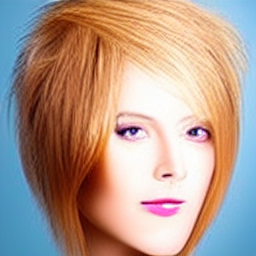

In [15]:
# Set up random generator with a specific seed for reproducibility
g_cpu = torch.Generator().manual_seed(888)

# Define prompts
prompts = ["A woman's face with blond hair"]

# Initialize the attention controller
controller = attention.AttentionStore()

# Generate and display images without running a baseline
images, x_t_blond = run_and_display(ldm,
    prompts=prompts,
    controller=controller,
    run_baseline=False,
    generator=g_cpu
)

### Output as per literature recommendation

The threshold is: 0.3, the cross_replace_steps is: 0.8, the self_replace_steps is: 0.2


  0%|          | 0/50 [00:00<?, ?it/s]

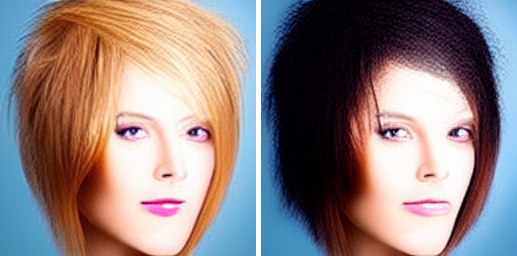

In [16]:
# Define prompts and words of interest
prompts = [
    "A woman's face with blond hair",
    "A woman's face with black hair"
]

words = ['blond', 'black']

threshold = 0.3
cross_replace_steps = 0.8
self_replace_steps = 0.2

# Print the parameter values for debugging
print(
    f"The threshold is: {threshold}, "
    f"the cross_replace_steps is: {cross_replace_steps}, "
    f"the self_replace_steps is: {self_replace_steps}"
)

# Instantiate the controller with attention replacement and local blend
controller = attention.AttentionReplace(
    tokenizer = tokenizer,
    prompts = prompts,
    num_steps = NUM_DIFFUSION_STEPS,
    cross_replace_steps=cross_replace_steps,
    self_replace_steps=self_replace_steps,
    local_blend=attention.LocalBlend(
        tokenizer=tokenizer,
        prompts=prompts,
        words=words,
        threshold=threshold
    )
)

# Run and display images
images, x_t = run_and_display(ldm,
    prompts = prompts,
    controller=controller,
    run_baseline=False,
    latent=x_t_blond,
    generator=g_cpu
)

The results demonstrate that using the parameter values reported in the literature—threshold = 0.3, cross_replace_steps = 0.8, and self_replace_steps = 0.2—is clearly insufficient for achieving precise image edits, specifically in changing hair color from blond to black. This suggests that the fixed parameters are not optimal for this type of detailed modification, and further exploration of more adaptive settings is necessary for improved accuracy.

The next section explores selected hyperparameters to enhance the explainability of the proposed method and improve editing precision across two domains: faces and landscapes.

### Study 01: Hyperparameter 01 (threshold k)

#### Hyperparameter 01 (threshold k) - Women's face with blond hair

In [17]:
prompts_faces = [
    "A woman's face with blond hair",
    "A woman's face with brown hair",
    "A woman's face with red hair",
    "A woman's face with black hair"
]
words_faces = [
    'blond',
    'brown',
    'red',
    'black'
]

# Varying 'threshold'
generated_images_threshold = generate_images_varying_single_param(
    param_name='threshold',
    param_range=np.linspace(0, 1, 11),
    prompts=prompts_faces,
    words=words_faces,
    tokenizer=tokenizer,
    ldm=ldm,
    latent=x_t_blond,
    num_steps=NUM_DIFFUSION_STEPS,
    show_images = False
)

save_images(
    generated_images_threshold,
    path_exp_01,
    filename = 'exp_01_param_threshold_faces.png'
)

save_images_as_gif(
    images=generated_images_threshold,
    gif_filename='exp_01_param_threshold_faces.gif',
    output_dir=path_exp_01,
    duration=3,
    loop=0
)

Output hidden; open in https://colab.research.google.com to view.

#### Hyperparameter 01 (threshold k) - A river between mountains

Create reference image

  0%|          | 0/50 [00:00<?, ?it/s]

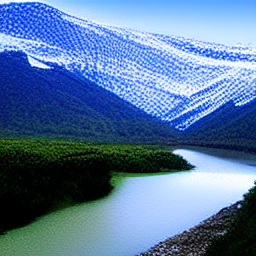

In [18]:
g_cpu = torch.Generator().manual_seed(888)
prompts = ["A river between mountains"]
controller = attention.AttentionStore()
images, x_t_mountain = run_and_display(
    ldm,
    prompts,
    controller,
    run_baseline=False,
    generator=g_cpu
)


In [19]:
prompts_landscapes = [
    "A river between mountains",
    "A street between mountains",
    "A forest between mountains",
    "A desert between mountains",
]

words_landscapes = [
    'river',
    "street",
    'forest',
    'desert'
]

generated_landscapes_threshold = generate_images_varying_single_param(
    param_name='threshold',
    param_range=np.linspace(0, 1, 11),
    prompts=prompts_landscapes,
    words=words_landscapes,
    tokenizer=tokenizer,
    ldm=ldm,
    latent=x_t_mountain,
    num_steps=NUM_DIFFUSION_STEPS,
    show_images = False
)

save_images(
    generated_landscapes_threshold,
    path_exp_01,
    filename = 'exp_01_param_threshold_landscapes.png'
)

save_images_as_gif(
    images=generated_landscapes_threshold,
    gif_filename='exp_01_param_threshold_landscapes.gif',
    output_dir=path_exp_01,
    duration=3,
    loop=0
)


Output hidden; open in https://colab.research.google.com to view.

### Study 02: Hyperparameter - cross-replace steps

#### Hyperparameter 02 (cross-replace steps) - Women's face with blond hair



Research 3 cases: Maintaining threshold at k = 0.3, reducing to 0, increasing to 0.6

cross_replace_steps: 0.2


  0%|          | 0/50 [00:00<?, ?it/s]

cross_replace_steps: 0.3


  0%|          | 0/50 [00:00<?, ?it/s]

cross_replace_steps: 0.4


  0%|          | 0/50 [00:00<?, ?it/s]

cross_replace_steps: 0.5


  0%|          | 0/50 [00:00<?, ?it/s]

cross_replace_steps: 0.6


  0%|          | 0/50 [00:00<?, ?it/s]

cross_replace_steps: 0.7


  0%|          | 0/50 [00:00<?, ?it/s]

cross_replace_steps: 0.8


  0%|          | 0/50 [00:00<?, ?it/s]

cross_replace_steps: 0.9


  0%|          | 0/50 [00:00<?, ?it/s]

cross_replace_steps: 1.0


  0%|          | 0/50 [00:00<?, ?it/s]

Figure saved at: /content/drive/My Drive/prompt-to-prompt/results/experiment_01_hyperparameters/exp_01_param_cross_replace_faces_01.png


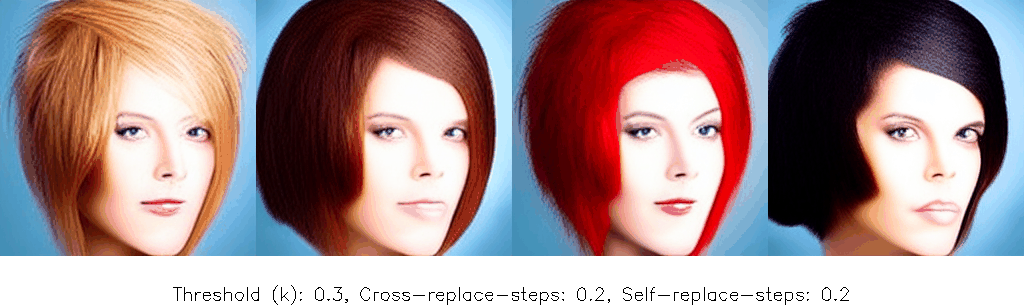

In [20]:
cross_replace_steps = [float(round(x,1)) for x in np.linspace(0.2, 1, 9)]


images_faces_cross_replace = generate_images_varying_single_param(
    param_name='cross_replace_steps',
    param_range=cross_replace_steps,
    prompts=prompts_faces,
    words=words_faces,
    tokenizer=tokenizer,
    ldm=ldm,
    latent=x_t_blond,
    num_steps=NUM_DIFFUSION_STEPS,
    show_images = False
)

save_images(
    images_faces_cross_replace,
    path_exp_01,
    filename = 'exp_01_param_cross_replace_faces_01.png'
)

save_images_as_gif(
    images=images_faces_cross_replace,
    gif_filename='exp_01_param_cross_replace_faces_01.gif',
    output_dir=path_exp_01,
    duration=1,
    loop=0
)




In [21]:
cross_replace_steps = [float(round(x,1)) for x in np.linspace(0.2, 1, 9)]
list_threshold = [0.3, 0, 0.6]

for index in range(len(list_threshold)):
  images_faces_cross_replace = generate_images_varying_single_param(
      param_name='cross_replace_steps',
      param_range=cross_replace_steps,
      prompts=prompts_faces,
      words=words_faces,
      tokenizer=tokenizer,
      ldm=ldm,
      latent=x_t_blond,
      num_steps=NUM_DIFFUSION_STEPS,
      show_images = False,
      threshold = list_threshold[index]
  )

  save_images(
      images_faces_cross_replace,
      path_exp_01,
      filename = f'exp_01_param_cross_replace_faces_0{index + 1}.png'
  )

  save_images_as_gif(
      images=images_faces_cross_replace,
      gif_filename=f'exp_01_param_cross_replace_faces_0{index + 1}.gif',
      output_dir=path_exp_01,
      duration=1,
      loop=0
  )

Output hidden; open in https://colab.research.google.com to view.

#### Hyperparameter Study 02 (cross-replace steps) - River between mountains

Exploration of 3 Cases: Maintaining threshold (k) at 0.3, reducing to 0, increasing to 0.6

In [22]:
cross_replace_steps = [float(round(x,1)) for x in np.linspace(0.2, 1, 9)]
list_threshold = [0.3, 0, 0.6]

for index in range(len(list_threshold)):
  images_landscapes_cross_replace = generate_images_varying_single_param(
      param_name='cross_replace_steps',
      param_range=cross_replace_steps,
      prompts=prompts_landscapes,
      words=words_landscapes,
      tokenizer=tokenizer,
      ldm=ldm,
      latent=x_t_mountain,
      num_steps=NUM_DIFFUSION_STEPS,
      show_images = False,
      threshold = list_threshold[index]
  )

  save_images(
      images_landscapes_cross_replace,
      path_exp_01,
      filename = f'exp_01_param_cross_replace_landscapes_0{index + 1}.png'
  )

  save_images_as_gif(
      images=images_landscapes_cross_replace,
      gif_filename=f'exp_01_param_cross_replace_landscapes_0{index + 1}.gif',
      output_dir=path_exp_01,
      duration=1,
      loop=0
  )

Output hidden; open in https://colab.research.google.com to view.

### study 03: Hyperparameter Study 03 - self-replace steps

#### Hyperparameter 03 (self-replace steps) - Women's face with blond hair

Three scenarios will be researched:
1) Default parameters for the threshold (k) and the cross-replace-steps parameters
2) Switching off the binary mask by setting the threshold to 0, reducing the cross-attention by setting cross-replace steps to 0.2
3) Switching off both the binary masking and the cross-attention mechanism

self_replace_steps: 0.0


  0%|          | 0/50 [00:00<?, ?it/s]

self_replace_steps: 0.1


  0%|          | 0/50 [00:00<?, ?it/s]

self_replace_steps: 0.2


  0%|          | 0/50 [00:00<?, ?it/s]

self_replace_steps: 0.4


  0%|          | 0/50 [00:00<?, ?it/s]

self_replace_steps: 0.5


  0%|          | 0/50 [00:00<?, ?it/s]

self_replace_steps: 0.6


  0%|          | 0/50 [00:00<?, ?it/s]

self_replace_steps: 0.8


  0%|          | 0/50 [00:00<?, ?it/s]

self_replace_steps: 0.9


  0%|          | 0/50 [00:00<?, ?it/s]

self_replace_steps: 1.0


  0%|          | 0/50 [00:00<?, ?it/s]

self_replace_steps: 0.0


  0%|          | 0/50 [00:00<?, ?it/s]

self_replace_steps: 0.1


  0%|          | 0/50 [00:00<?, ?it/s]

self_replace_steps: 0.2


  0%|          | 0/50 [00:00<?, ?it/s]

self_replace_steps: 0.4


  0%|          | 0/50 [00:00<?, ?it/s]

self_replace_steps: 0.5


  0%|          | 0/50 [00:00<?, ?it/s]

self_replace_steps: 0.6


  0%|          | 0/50 [00:00<?, ?it/s]

self_replace_steps: 0.8


  0%|          | 0/50 [00:00<?, ?it/s]

self_replace_steps: 0.9


  0%|          | 0/50 [00:00<?, ?it/s]

self_replace_steps: 1.0


  0%|          | 0/50 [00:00<?, ?it/s]

self_replace_steps: 0.0


  0%|          | 0/50 [00:00<?, ?it/s]

self_replace_steps: 0.1


  0%|          | 0/50 [00:00<?, ?it/s]

self_replace_steps: 0.2


  0%|          | 0/50 [00:00<?, ?it/s]

self_replace_steps: 0.4


  0%|          | 0/50 [00:00<?, ?it/s]

self_replace_steps: 0.5


  0%|          | 0/50 [00:00<?, ?it/s]

self_replace_steps: 0.6


  0%|          | 0/50 [00:00<?, ?it/s]

self_replace_steps: 0.8


  0%|          | 0/50 [00:00<?, ?it/s]

self_replace_steps: 0.9


  0%|          | 0/50 [00:00<?, ?it/s]

self_replace_steps: 1.0


  0%|          | 0/50 [00:00<?, ?it/s]

Figure saved at: /content/drive/My Drive/prompt-to-prompt/results/experiment_01_hyperparameters/exp_01_param_self_replace_faces_03.png


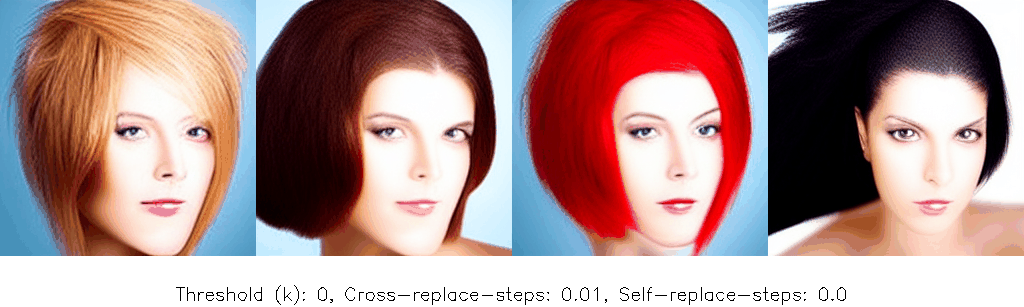

In [23]:
list_cross_replace_steps=[.8, 0.2, 0.01]
list_threshold = [0.3, 0, 0]
self_replace_steps = [float(round(x,1)) for x in np.linspace(0, 1, 9)]

for index in range(len(list_threshold)):
    images_faces_self_replace = generate_images_varying_single_param(
    param_name='self_replace_steps',
    param_range=self_replace_steps,
    prompts=prompts_faces,
    words=words_faces,
    tokenizer=tokenizer,
    ldm=ldm,
    latent=x_t_blond,
    num_steps=NUM_DIFFUSION_STEPS,
    show_images = False,
    cross_replace_steps = list_cross_replace_steps[index],
    threshold = list_threshold[index]
)

save_images(
    images_faces_self_replace,
    path_exp_01,
    filename = f'exp_01_param_self_replace_faces_0{index + 1}.png'
)

save_images_as_gif(
    images=images_faces_self_replace,
    gif_filename=f'exp_01_param_self_replace_faces_0{index + 1}.gif',
    output_dir=path_exp_01,
    duration=1,
    loop=0
)

#### Hyperparameter 03 (self-replace steps) - River between mountains

Three scenarios will be researched:
1) Default parameters for the threshold (k) and the cross-replace-steps parameters
2) Switching off the binary mask by setting the threshold to 0, reducing the cross-attention by setting cross-replace steps to 0.2
3) Switching off both the binary masking and the cross-attention mechanism

In [ ]:
list_cross_replace_steps=[.8, 0.2, 0.01]
list_threshold = [0.3, 0, 0]
self_replace_steps = [float(round(x,1)) for x in np.linspace(0, 1, 9)]

for index in range(len(list_threshold)):
  gen_landsc_self_replace = generate_images_varying_single_param(
      param_name='self_replace_steps',
      param_range=self_replace_steps,
      prompts=prompts_landscapes,
      words=words_landscapes,
      tokenizer=tokenizer,
      ldm=ldm,
      latent=x_t_mountain,
      num_steps=NUM_DIFFUSION_STEPS,
      show_images = False,
      cross_replace_steps=list_cross_replace_steps[index],
      threshold = list_threshold[index]
  )

  save_images(
      gen_landsc_self_replace,
      path_exp_01,
      filename = f'exp_01_param_seld_replace_landscapes_0{index + 1}.png'
  )

  save_images_as_gif(
      images=gen_landsc_self_replace,
      gif_filename=f'exp_01_param_self_replace_steps_landscapes_0{index + 1}.gif',
      output_dir=path_exp_01,
      duration=1,
      loop=0
  )

Output hidden; open in https://colab.research.google.com to view.

## **Final optimized result: self-attention is all you need**

Based on the hyperparameter study above we have selected the following set of parameters and deemed them as optimal for the use case of hair color changing.

### Self-replace steps = 0.8, cross-replace steps = 0.2 and threshold (k) = 0

self_replace_steps: 0.8


  0%|          | 0/50 [00:00<?, ?it/s]

Figure saved at: /content/drive/My Drive/prompt-to-prompt/results/experiment_01_hyperparameters/exp_01_final_results_faces.png


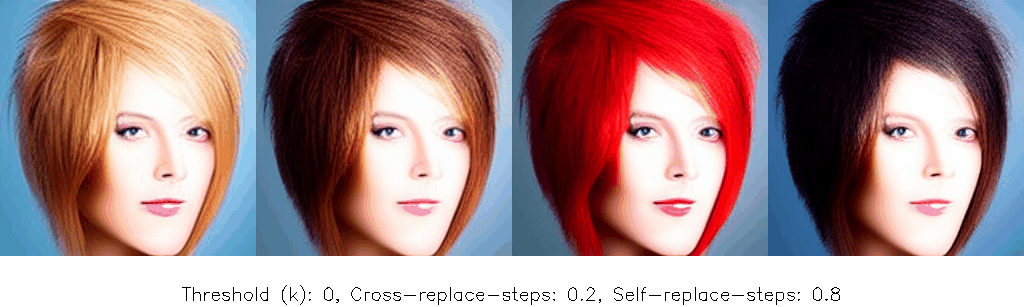

In [25]:
cross_replace_steps = 0.2
threshold = 0
self_replace_steps = [0.8]

final_images_faces = generate_images_varying_single_param(
param_name='self_replace_steps',
param_range=self_replace_steps,
prompts=prompts_faces,
words=words_faces,
tokenizer=tokenizer,
ldm=ldm,
latent=x_t_blond,
num_steps=NUM_DIFFUSION_STEPS,
show_images = False,
cross_replace_steps = cross_replace_steps,
threshold = threshold
)

save_images(
final_images_faces,
path_exp_01,
filename = f'exp_01_final_results_faces.png'
)

save_images_as_gif(
images=final_images_faces,
gif_filename=f'exp_01_final_results_faces{index + 1}.gif',
output_dir=path_exp_01,
duration=1,
loop=0
)